In [15]:
import os
import music21
import zipfile
import json
import tensorflow.keras as keras
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
SAVE_DIR="dataset"
SINGLE_FILE_PATH="single_file_data/song_data"
MAPPING_FILE_PATH="mappings/mapping.json"
SEQUENCE_LENGTH=32
SAVE_MODEL_PATH='lstm_song_generator.h5'

In [5]:
def load_songs_in_kern_format(dataset_path):
  song_list=[]
  for path,subdirs,files in os.walk(dataset_path):
    for file in files:
      if file[-4:]==".krn":
        song=music21.converter.parse(os.path.join(path,file))
        song_list.append(song)
  return song_list



ACCEPTABLE_DURATIONS=[0.25,0.5,0.75,1,1.5,2,3,4]

def has_acceptible_duration(song,acceptable_durations):
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True



def transpose(song):
    parts=song.getElementsByClass(music21.stream.Part)
    measure_part0=parts[0].getElementsByClass(music21.stream.Measure)
    key=measure_part0[0][4]
    
    if not isinstance(key,music21.key.Key):
        key=song.analyze("key")
    
    if key.mode=="major":
        interval=music21.interval.Interval(key.tonic,music21.pitch.Pitch("C"))
    elif key.mode=="minor":
        interval=music21.interval.Interval(key.tonic,music21.pitch.Pitch("A"))
        
    transposed_song=song.transpose(interval)
    return transposed_song
    
    
    
def encode_song(song,time_step=0.25):
    #pitch=60 duration=1.0--->{60,"_","_","_"}
    encoded_song=[]
    for event in song.flat.notesAndRests:
        #handle notes
        if isinstance(event,music21.note.Note):
            symbol=event.pitch.midi #60
        elif isinstance(event,music21.note.Rest):
            symbol="r"
        #Convert the notes or rests into time series
        steps= int(event.duration.quarterLength/time_step)
        for step in range(steps):
            if step==0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")
    #cast the song to a string\
    encoded_song=" ".join(map(str,encoded_song))
    return encoded_song


def load(filepath):
    with open(filepath,"r") as fp:
        song=fp.read()
    return song

def create_single_file_dataset(dataset_path,file_dataset_path,sequence_length):
    new_song_delimiter="/ "*sequence_length
    songs=""
    for path,_,files in os.walk(dataset_path):
        for file in files:
            filepath=os.path.join(path,file)
            song=load(filepath)
            songs+=song+" "+new_song_delimiter
    songs=songs[:-1]
    with open(file_dataset_path,"w") as fp:
        fp.write(songs)
    return songs



def create_mapping(songs,mapping_file_path):
    mapping_dictionary={}
    songs=songs.split()
    vocaublary=list(set(songs))
    for i, symbol in enumerate(vocaublary):
        mapping_dictionary[symbol]=i
    #save as .json file
    with open(mapping_file_path,"w") as fp:
        json.dump(mapping_dictionary,fp)
    return mapping_dictionary

def convert_songs_to_integers(songs,mapping_file_path):
    int_songs=[]
    with open(mapping_file_path,"r") as fp:
        mappings=json.load(fp)
    songs=songs.split()
    for symbol in songs:
        int_songs.append(mappings[symbol])
    return int_songs

def generating_training_seq(sequence_length):
    #inputs are fixed length time series of length=sequence_length
    #[11,12,13,14...]
    #[11,12]->[13], [12,13]->[14] and so on...
    
    songs=load(SINGLE_FILE_PATH)
    int_songs=convert_songs_to_integers(songs,MAPPING_FILE_PATH)
    
    inputs=[]
    targets=[]
    
    n_sequences=len(int_songs)-sequence_length
    for i in range(n_sequences):
        inputs.append(int_songs[i:(i+sequence_length)])
        targets.append(int_songs[i+sequence_length])
    
    #one hot encoding the sequences
    #[[0,1,2],[1,2,1]]-->[ [ [1,0,0] , [0,1,0] , [0,0,1] ] , [ [0,1,0],[0,0,1],[0,1,0] ] ]
    vocabulary_size=len(set(int_songs))
    inputs=keras.utils.to_categorical(inputs,vocabulary_size)
    targets=np.array(targets)
    return inputs,targets

In [6]:
songs=load_songs_in_kern_format(r"C:\Users\padma\OneDrive\Desktop\essen\europa\deutschl\test")
print("Loaded {} songs".format(len(songs)))

Loaded 12 songs


In [7]:
us = music21.environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
us['musicxmlPath']

WindowsPath('C:/Program Files/MuseScore 4/bin/MuseScore4.exe')

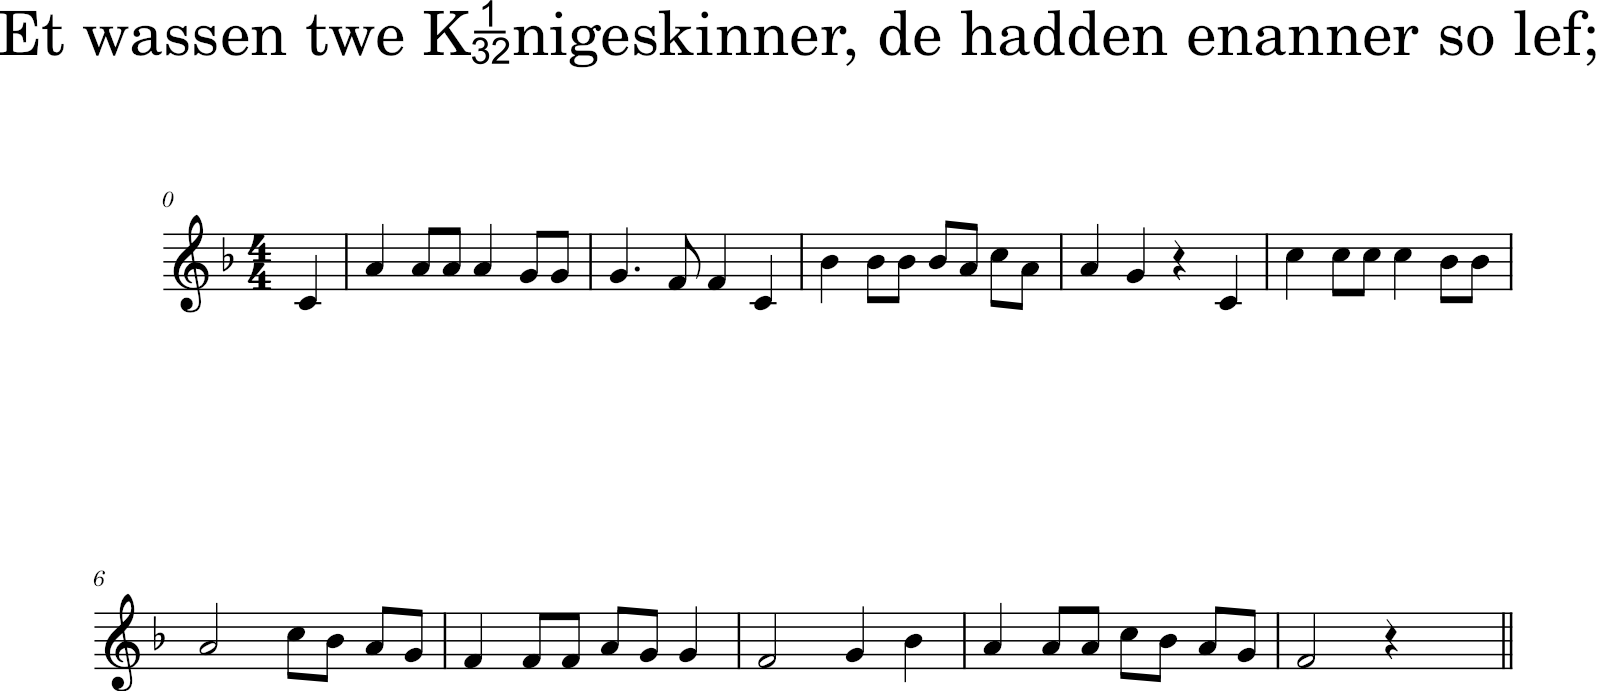

In [8]:
songs[2].show()

Visualization of how an encoded string looks like

In [9]:
encode_song(songs[2])

C:\Users\padma\anaconda3\envs\DLENV\lib\site-packages\music21\stream\base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


'60 _ _ _ 69 _ _ _ 69 _ 69 _ 69 _ _ _ 67 _ 67 _ 67 _ _ _ _ _ 65 _ 65 _ _ _ 60 _ _ _ 70 _ _ _ 70 _ 70 _ 70 _ 69 _ 72 _ 69 _ 69 _ _ _ 67 _ _ _ r _ _ _ 60 _ _ _ 72 _ _ _ 72 _ 72 _ 72 _ _ _ 70 _ 70 _ 69 _ _ _ _ _ _ _ 72 _ 70 _ 69 _ 67 _ 65 _ _ _ 65 _ 65 _ 69 _ 67 _ 67 _ _ _ 65 _ _ _ _ _ _ _ 67 _ _ _ 70 _ _ _ 69 _ _ _ 69 _ 69 _ 72 _ 70 _ 69 _ 67 _ 65 _ _ _ _ _ _ _ r _ _ _'

The kern representation can be used to represent basic or core information for common Western music. The kern scheme can be used to encode pitch and duration, plus other common score-related information.

In [38]:
def preprocess_songs(dataset_path):
    print("Loading songs ...")
    songs=load_songs_in_kern_format(dataset_path)
    print("Loaded {} songs.".format(len(songs)))
    i=0
    for song in songs:
        #removing non-acceptible songs
        if(not has_acceptible_duration(song,ACCEPTABLE_DURATIONS)):
            continue
        #transpose the song to Cmaj/Amin
        song=transpose(song)
        #encode the song and return the string
        encoded_song=encode_song(song)
        save_path=os.path.join(SAVE_DIR,str(i))
        i+=1
        with open(save_path,"w") as fp:
            fp.write(encoded_song)

In [39]:
preprocess_songs(r"C:\Users\padma\OneDrive\Desktop\essen\europa\deutschl\erk")

Loading songs ...
Loaded 1700 songs.


In [42]:
songs=create_single_file_dataset(SAVE_DIR,SINGLE_FILE_PATH,32)

songs have characters which cant be parsed by any neural network. So we need to map these elements from a look up vocabulary.

In [43]:
mapping_dictionary=create_mapping(songs,MAPPING_FILE_PATH)

LSTM 

In [47]:
OUTPUT_UNITS=len(mapping_dictionary)
NUM_UNITS=[256]
loss=tf.keras.losses.SparseCategoricalCrossentropy()
def build_model(n_units,loss_fn,learning_rate,output_units=OUTPUT_UNITS):
    #no.of inputs,no.of units in a one hot encoded vector
    #this input is for one time step
    input=tf.keras.layers.Input(shape=(None,output_units))
    x=tf.keras.layers.LSTM(n_units[0])(input)
    x=tf.keras.layers.Dropout(0.2)(x)
    output= keras.layers.Dense(output_units,activation='softmax')(x)
    model=tf.keras.Model(input,output)
    model.compile(loss=loss_fn,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=['accuracy'])
    model.summary()
    return model
    
    
    

In [48]:
model=build_model(NUM_UNITS,loss,0.001,OUTPUT_UNITS)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 lstm (LSTM)                 (None, 256)               302080    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 38)                9766      
                                                                 
Total params: 311,846
Trainable params: 311,846
Non-trainable params: 0
_________________________________________________________________


In [49]:
inputs,targets=generating_training_seq(32)

In [ ]:
model.fit(inputs,targets,epochs=100,batch_size=64)
model.save(SAVE_MODEL_PATH)

In [53]:
model.save(SAVE_MODEL_PATH)

In [22]:
class MelodyGenerator():
    def __init__(self,model_path="lstm_song_generator.h5"):
        self.model_path=model_path
        self.model=tf.keras.models.load_model(self.model_path)
        with open(MAPPING_FILE_PATH,"r") as fp:
            self.mappings=json.load(fp)
        self._start_symbols= ["/"]*SEQUENCE_LENGTH
    
    def generate(self,seed,num_steps,max_sequence_length,temperature):
        #create seed with start symbols
        seed=seed.split()
        melody=seed
        seed=self._start_symbols+seed
        #map to integers
        seed=[self.mappings[symbol] for symbol in seed]
        
        for _ in range(num_steps):
            #limit the seed to max sequence length
            seed=seed[-max_sequence_length:]
            #one_hot encode
            one_hot_seed=tf.expand_dims(tf.keras.utils.to_categorical(seed,num_classes=len(self.mappings)),axis=0)
            #this produces a 2D array of (max_sequence_length,38)
            probabilities=self.model.predict(one_hot_seed)[0]
            output_int=self.sample_with_temperature(probabilities,temperature)
            
            #update the seed
            seed.append(output_int)
            
            #map input to our encoding
            output_symbol=[k for k,v in self.mappings.items() if v==output_int][0]
            if output_symbol=="/":
                break
            melody.append(output_symbol)
        return melody
    
    def sample_with_temperature(self,probabilities,temperature):
        #temp->infinity makes prob.dist uniform
        #temp->0 makes it highly selective and rigid
        #set temp=1
        predictions=np.log(probabilities)/temperature
        probabilities=np.exp(predictions)/np.sum(np.exp(predictions))
        choices=range(len(probabilities))
        index=np.random.choice(choices,p=probabilities)
        return index
    
    def save_melody(self,melody,step_duration=0.25,format="midi",file_name="generated_melody.midi"):
        stream=music21.stream.Stream() #init a music21 stream
        start_symbol=None
        step_count=1
        for i,symbol in enumerate(melody):
            if ((symbol!="_") or (i==len(melody)-1)):
                if start_symbol is not None:
                    quarter_length_duration=step_duration*step_count
                    
                    #rest
                    if start_symbol=="r":
                        m21_event=music21.note.Rest(quarterLength=quarter_length_duration)
                    #note
                    else:
                        m21_event=music21.note.Note(int(start_symbol),quarterLength=quarter_length_duration)
                    stream.append(m21_event)
                    step_count=1
                start_symbol=symbol
            else:
                step_count+=1
                    
        stream.write(format,file_name)

In [29]:
gen=MelodyGenerator()
seed="55 _ 60 _ 64 _ 60 _ _ _ 59 _ 60 _ 62 _ 64 _ 60 _ _ _ r _ 60 _ 64 _ 67 _ 67 _ _ 65 64 _ 62 _ 60"
melody=gen.generate(seed,500,SEQUENCE_LENGTH,0.8)
gen.save_melody(melody)

1/1 [==============================] - 0s 33ms/step
